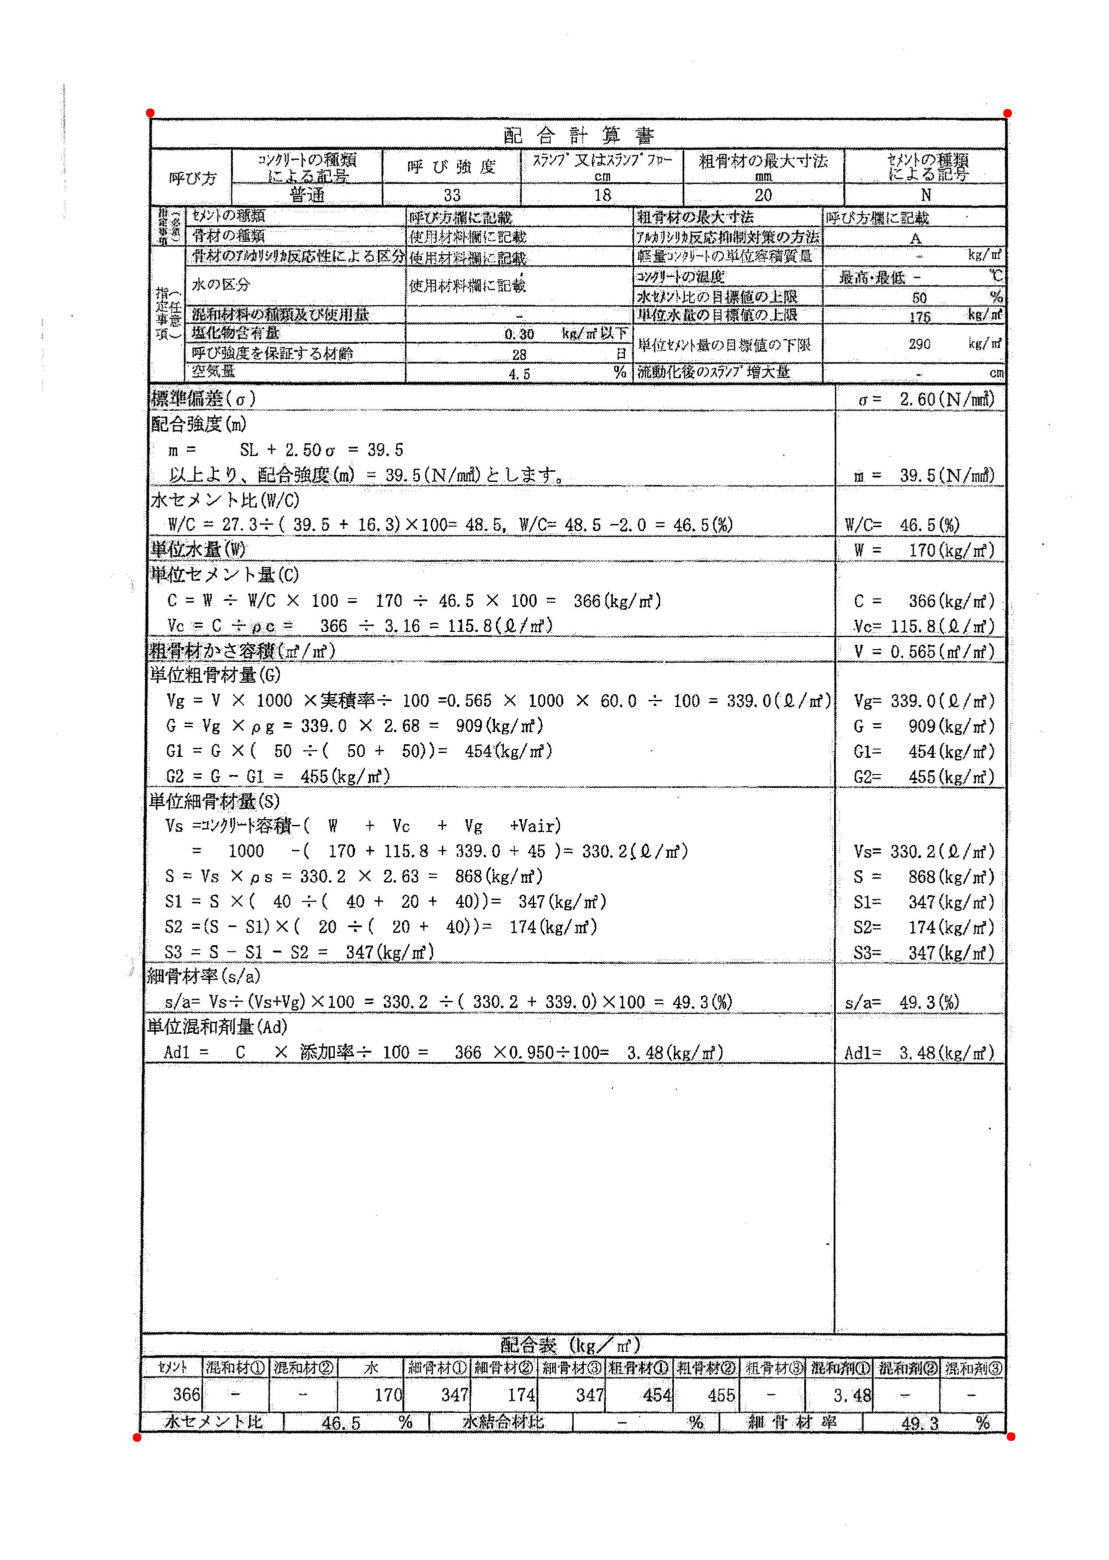

In [221]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh đầu vào
number_image = 4
image_path = 'image_input/image_table_' + str(number_image) + '.jpg'
image = cv2.imread(image_path)

# Làm sắc nét ảnh bằng bộ lọc Gaussian
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

# Chuyển đổi ảnh sang xám
gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

# Sử dụng Canny để phát hiện cạnh
edges = cv2.Canny(gray, 50, 150)

# Áp dụng phép giãn và phép đóng để lấp đầy các khoảng trống
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

# Tìm đường bao ngoài cùng
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Vẽ đường bao lên ảnh gốc
output_image = image.copy()
if contours:
    # Tìm contour lớn nhất, tức là khung bao ngoài cùng
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Xấp xỉ contour thành một đa giác
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Lấy 4 điểm góc của contour
    if len(approx) == 4:
        corner_points = approx.reshape(4, 2)
    else:
        rect = cv2.minAreaRect(largest_contour)
        corner_points = cv2.boxPoints(rect)
        corner_points = np.int0(corner_points)
    
    # Vẽ 4 điểm góc lên ảnh
    for point in corner_points:
        cv2.circle(output_image, tuple(point), 10, (0, 0, 255), -1)

# Hiển thị ảnh kết quả
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Code thực nghiệm kết quả của contour và transform ##

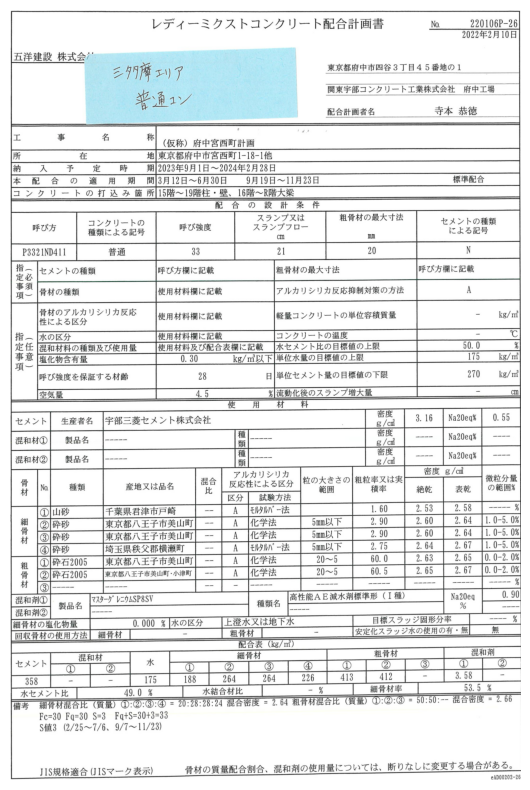

In [222]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh đầu vào
number_image = 10
image_path = 'image_input/image_table_' + str(number_image) + '.jpg'
image = cv2.imread(image_path)

# Làm sắc nét ảnh bằng bộ lọc
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

# Chuyển đổi ảnh sang xám
gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)

# Sử dụng Canny để phát hiện cạnh
edges = cv2.Canny(gray, 50, 150)

# Áp dụng phép giãn và phép đóng để lấp đầy các khoảng trống
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

# Tìm đường bao ngoài cùng
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Tìm contour lớn nhất
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Xấp xỉ contour thành một đa giác
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Lấy 4 điểm góc của contour, nếu không đủ 4 điểm thì dùng bounding box
    if len(approx) == 4:
        corner_points = approx.reshape(4, 2)
    else:
        rect = cv2.minAreaRect(largest_contour)
        corner_points = cv2.boxPoints(rect)
        corner_points = np.int0(corner_points)
    
    # Sắp xếp các điểm theo thứ tự (top-left, top-right, bottom-right, bottom-left)
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    box = order_points(corner_points)

    # Tính kích thước của bounding box
    width = int(np.linalg.norm(box[1] - box[0]))
    height = int(np.linalg.norm(box[2] - box[1]))

    # Tạo ma trận biến đổi phối cảnh
    dst_pts = np.array([
        [0, 0],
        [width-1, 0],
        [width-1, height-1],
        [0, height-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(box, dst_pts)

    # Áp dụng phép biến đổi phối cảnh để lấy hình ảnh mới chứa contour
    warped = cv2.warpPerspective(image, M, (width, height))

    # Hiển thị ảnh mới chứa contour
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


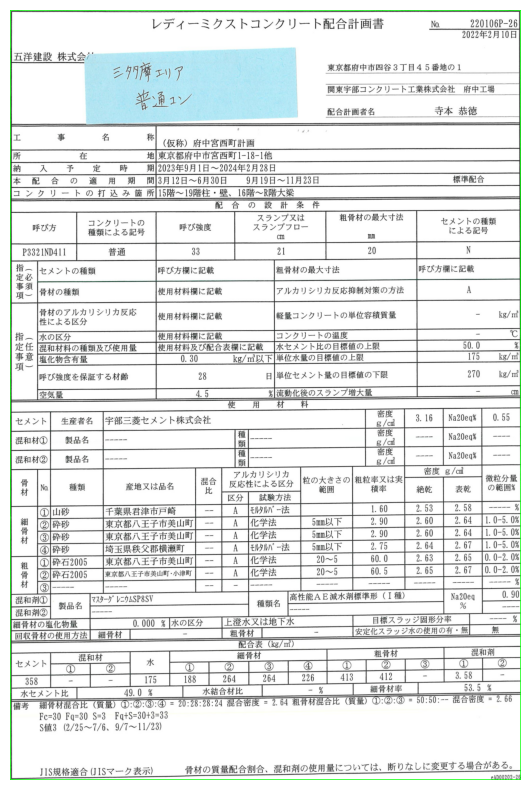

In [223]:
# Tạo một bản sao của ảnh đã biến đổi
# warped_with_rectangle = warped.copy()

# Chuyển đổi các điểm trong dst_pts sang tuple của số nguyên
dst_pts_int = [tuple(map(int, pt)) for pt in dst_pts]

# Vẽ các đường thẳng nối các điểm trong dst_pts_int
cv2.line(warped, dst_pts_int[0], dst_pts_int[1], (0, 255, 0), 4)
cv2.line(warped, dst_pts_int[1], dst_pts_int[2], (0, 255, 0), 4)
cv2.line(warped, dst_pts_int[2], dst_pts_int[3], (0, 255, 0), 4)
cv2.line(warped, dst_pts_int[3], dst_pts_int[0], (0, 255, 0), 4)

# Hiển thị ảnh mới chứa contour với các đường thẳng bao quanh
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Đoạn code thực hiện lấy các khung của hình ##

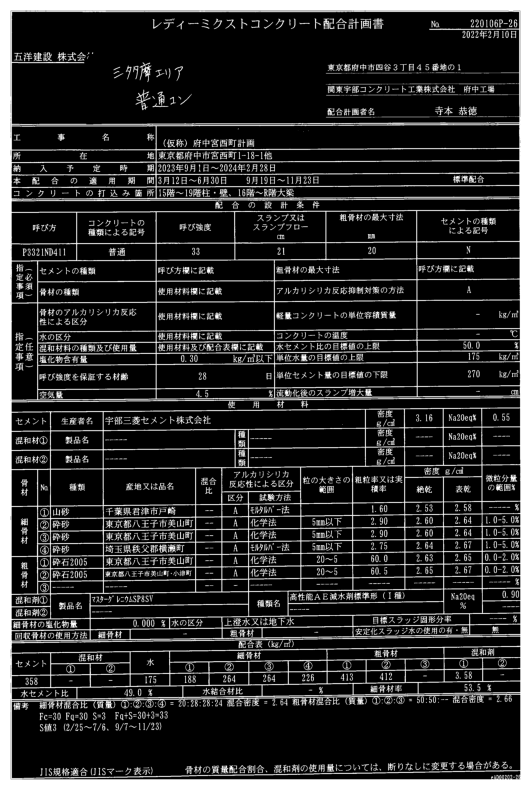

In [224]:
image_new = warped.copy()

# Chuyển ảnh sang xám
image_process = cv2.cvtColor(image_new, cv2.COLOR_BGR2GRAY)

# Thresholding
_, image_process = cv2.threshold(image_process, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Inverting
image_process = cv2.bitwise_not(image_process)

plt.figure(figsize=(10, 10))
plt.imshow(image_process, cmap='gray')
plt.axis('off')
plt.show()

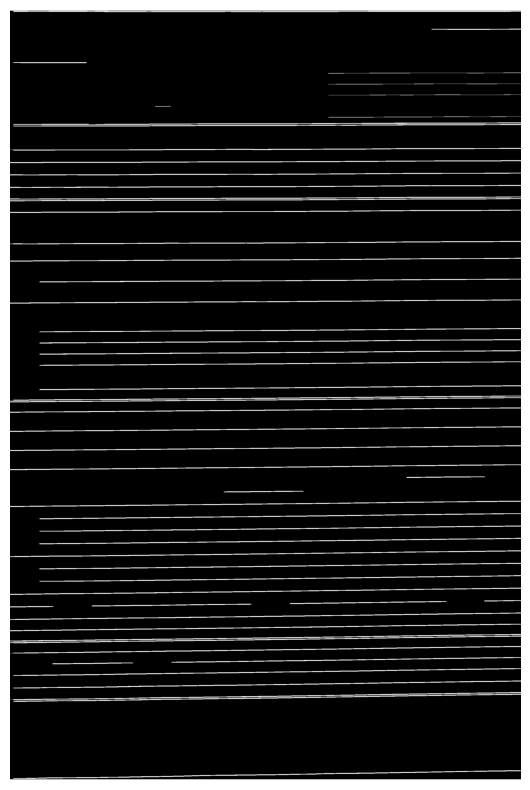

In [225]:
hor = np.array([[1,1,1,1,1,1]])
vertical_lines_eroded_image = cv2.erode(image_process, hor, iterations=10)
vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=10)

plt.figure(figsize=(10, 10))
plt.imshow(vertical_lines_eroded_image, cmap='gray')
plt.axis('off')
plt.show()

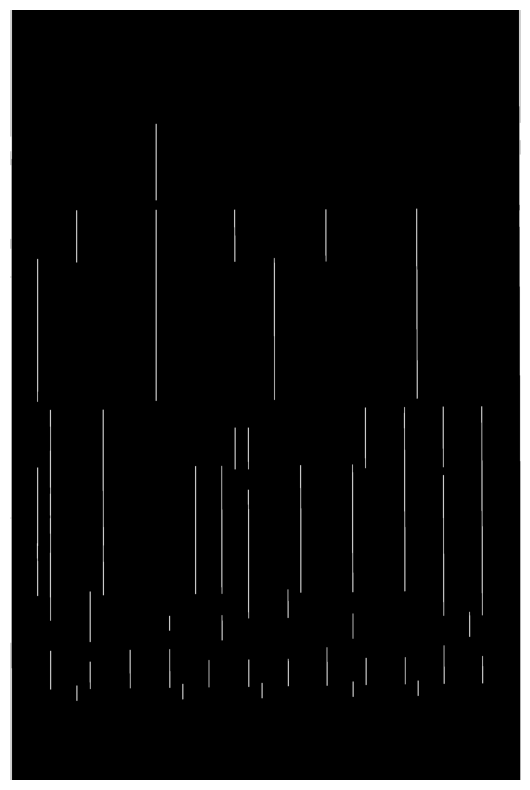

In [226]:
ver = np.array([[1],
            [1],
            [1],
            [1],
            [1],
            [1],
            [1]])
horizontal_lines_eroded_image = cv2.erode(image_process, ver, iterations=8)
horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=10)

plt.figure(figsize=(10, 10))
plt.imshow(horizontal_lines_eroded_image, cmap='gray')
plt.axis('off')
plt.show()

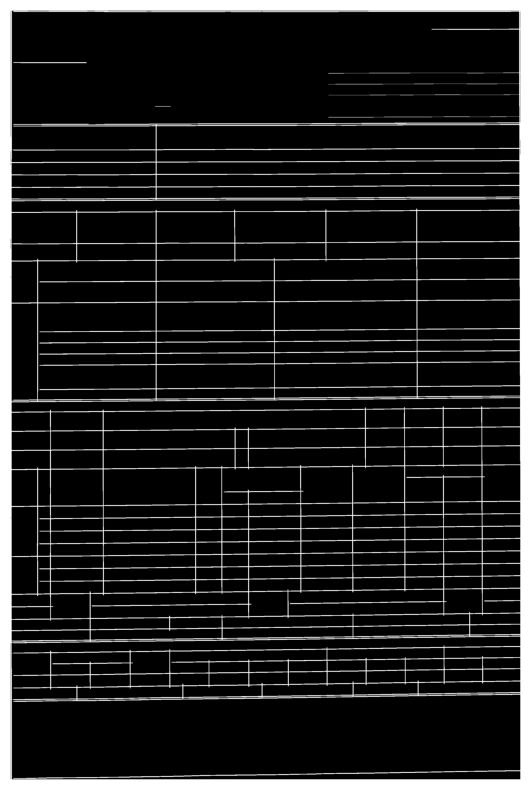

In [227]:
combined_image = cv2.add(vertical_lines_eroded_image, horizontal_lines_eroded_image)
plt.figure(figsize=(10, 10))
plt.imshow(combined_image, cmap='gray')
plt.axis('off')
plt.show()

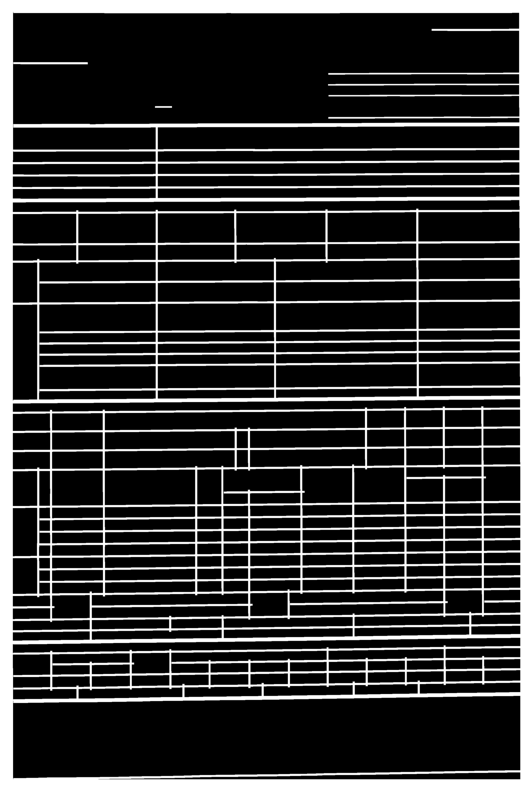

In [228]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)
plt.figure(figsize=(10, 10))
plt.imshow(combined_image_dilated, cmap='gray')
plt.axis('off')
plt.show()

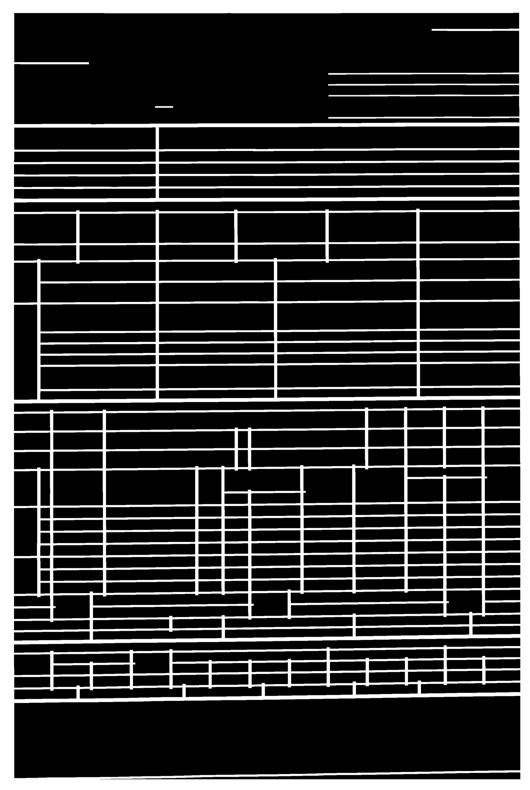

In [229]:
# Tạo ma trận dịch ảnh sang phải
rows, cols = combined_image_dilated.shape
translation_matrix = np.float32([[1, 0, 5], [0, 1, 0]])

# Dịch ảnh sang phải
shifted_image = cv2.warpAffine(combined_image_dilated, translation_matrix, (cols, rows))

# Kết hợp ảnh gốc và ảnh đã dịch
extended_image = cv2.bitwise_or(combined_image_dilated, shifted_image)

# Hiển thị ảnh kết quả
plt.figure(figsize=(10, 10))
plt.imshow(extended_image, cmap='gray')
plt.axis('off')
plt.show()

In [230]:
combined_image_dilated = extended_image.copy()

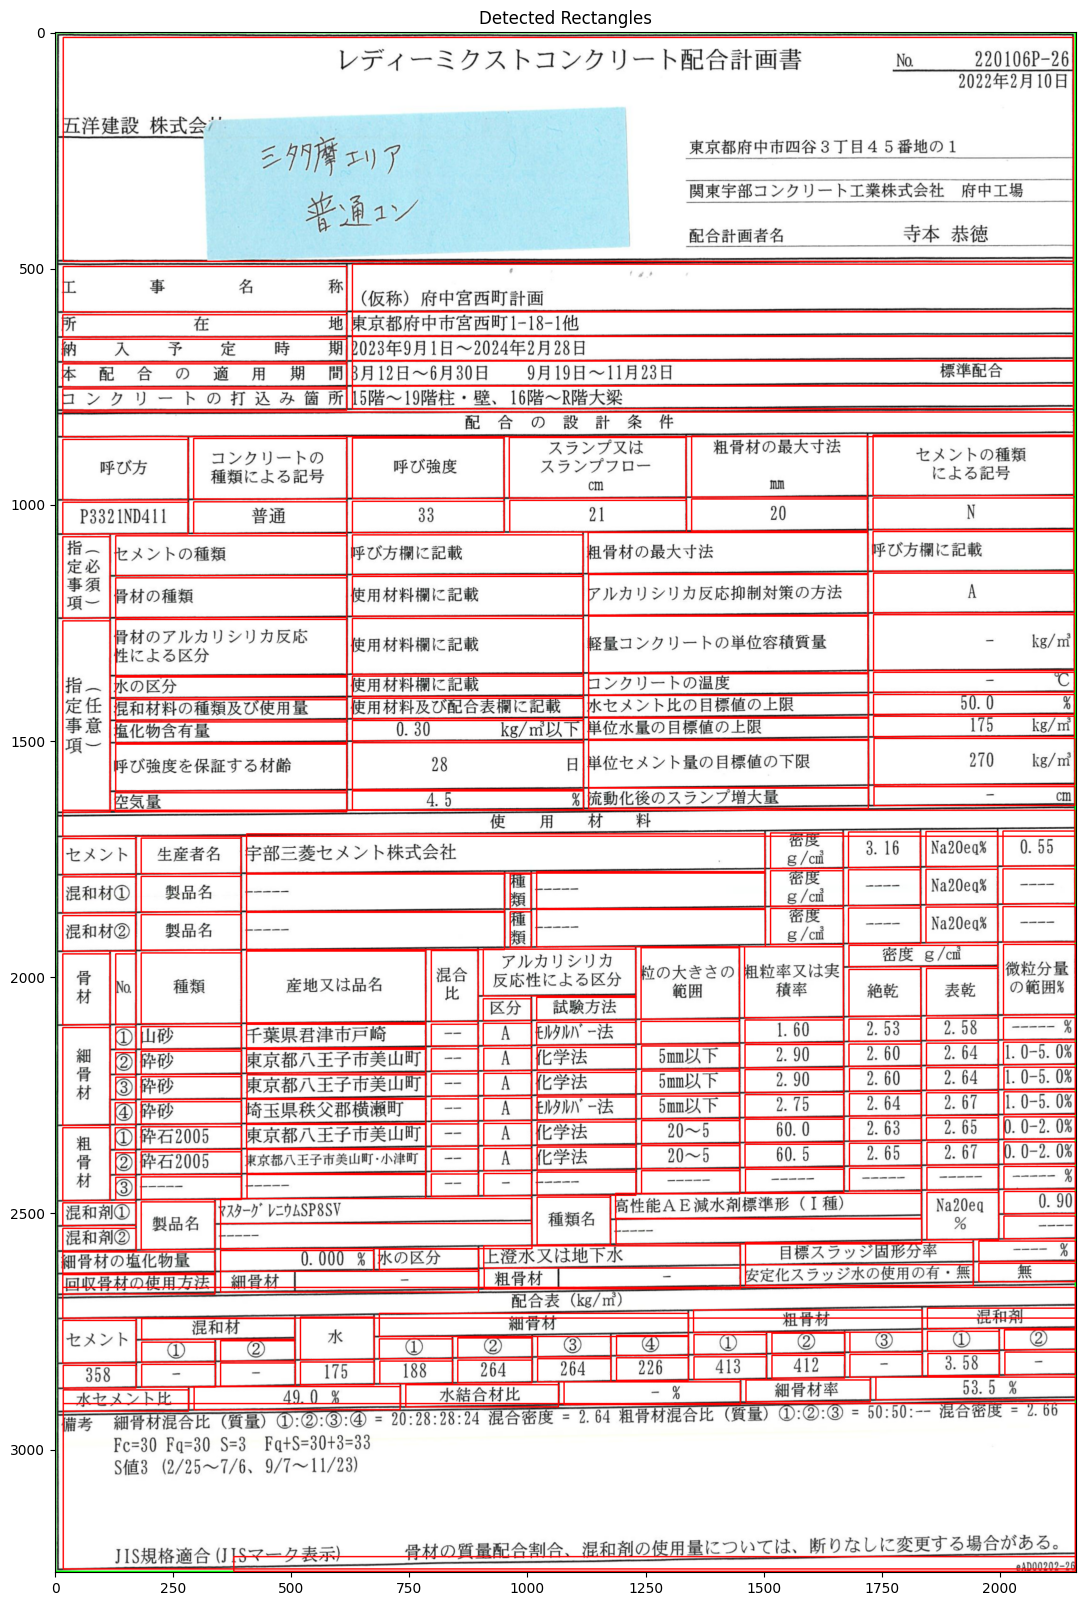

Detected Rectangles:
Rectangle 1: x=17, y=11, width=2138, height=474
Rectangle 2: x=17, y=2903, width=2142, height=350
Rectangle 3: x=629, y=491, width=1526, height=100
Rectangle 4: x=16, y=2657, width=2143, height=65
Rectangle 5: x=16, y=1647, width=2142, height=55
Rectangle 6: x=16, y=804, width=2140, height=52
Rectangle 7: x=405, y=1697, width=1097, height=83
Rectangle 8: x=629, y=696, width=1526, height=52
Rectangle 9: x=629, y=644, width=1526, height=51
Rectangle 10: x=629, y=592, width=1526, height=51
Rectangle 11: x=629, y=749, width=1526, height=48
Rectangle 12: x=1129, y=1236, width=591, height=120
Rectangle 13: x=1129, y=1499, width=592, height=100
Rectangle 14: x=128, y=1243, width=489, height=119
Rectangle 15: x=405, y=1945, width=379, height=152
Rectangle 16: x=17, y=496, width=600, height=96
Rectangle 17: x=629, y=1241, width=488, height=118
Rectangle 18: x=378, y=3227, width=1781, height=31
Rectangle 19: x=1731, y=853, width=425, height=128
Rectangle 20: x=1128, y=1059, 

In [231]:
# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
count = 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    area = cv2.contourArea(contour)
    if area > 1000 and w > 10 and h > 10 and h < line_image.shape[0]:
        count += 1
        rectangles.append((x, y, w, h))
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ

rectangles_sorted = sorted(rectangles, key=lambda rect: rect[2] * rect[3], reverse=True)

# Hiển thị ảnh với các bounding box đã vẽ
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
plt.title('Detected Rectangles')
plt.show()

# In ra các hình chữ nhật trích xuất được
print("Detected Rectangles:")
for i, (x, y, w, h) in enumerate(rectangles_sorted, 1):
    print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")

Selected Rectangles:
Rectangle 1: x=1731, y=853, width=425, height=128
Rectangle 2: x=1347, y=855, width=372, height=129
Rectangle 3: x=961, y=858, width=374, height=128
Rectangle 4: x=629, y=859, width=321, height=128
Rectangle 5: x=293, y=860, width=324, height=128
Rectangle 6: x=16, y=862, width=265, height=128
Percent Rectangles:
Percent Rectangles:
Rectangle 1: x=742, y=2863, width=323, height=47
Rectangle 2: x=1737, y=2847, width=422, height=48
Rectangle 3: x=1462, y=2853, width=263, height=46
Rectangle 4: x=1077, y=2857, width=373, height=48
Rectangle 5: x=294, y=2867, width=436, height=49
Rectangle 6: x=17, y=2874, width=265, height=45
x(max) = 2159, y(max) = 2919
Selected Rectangle: x=16, y=2657, width=2143, height=65
Second data area: x_min_2=16, y_min_2=2657, x_max_2=2159, y_max_2=2919
(17, 11, 2138, 474)
(16, 804, 2140, 52)


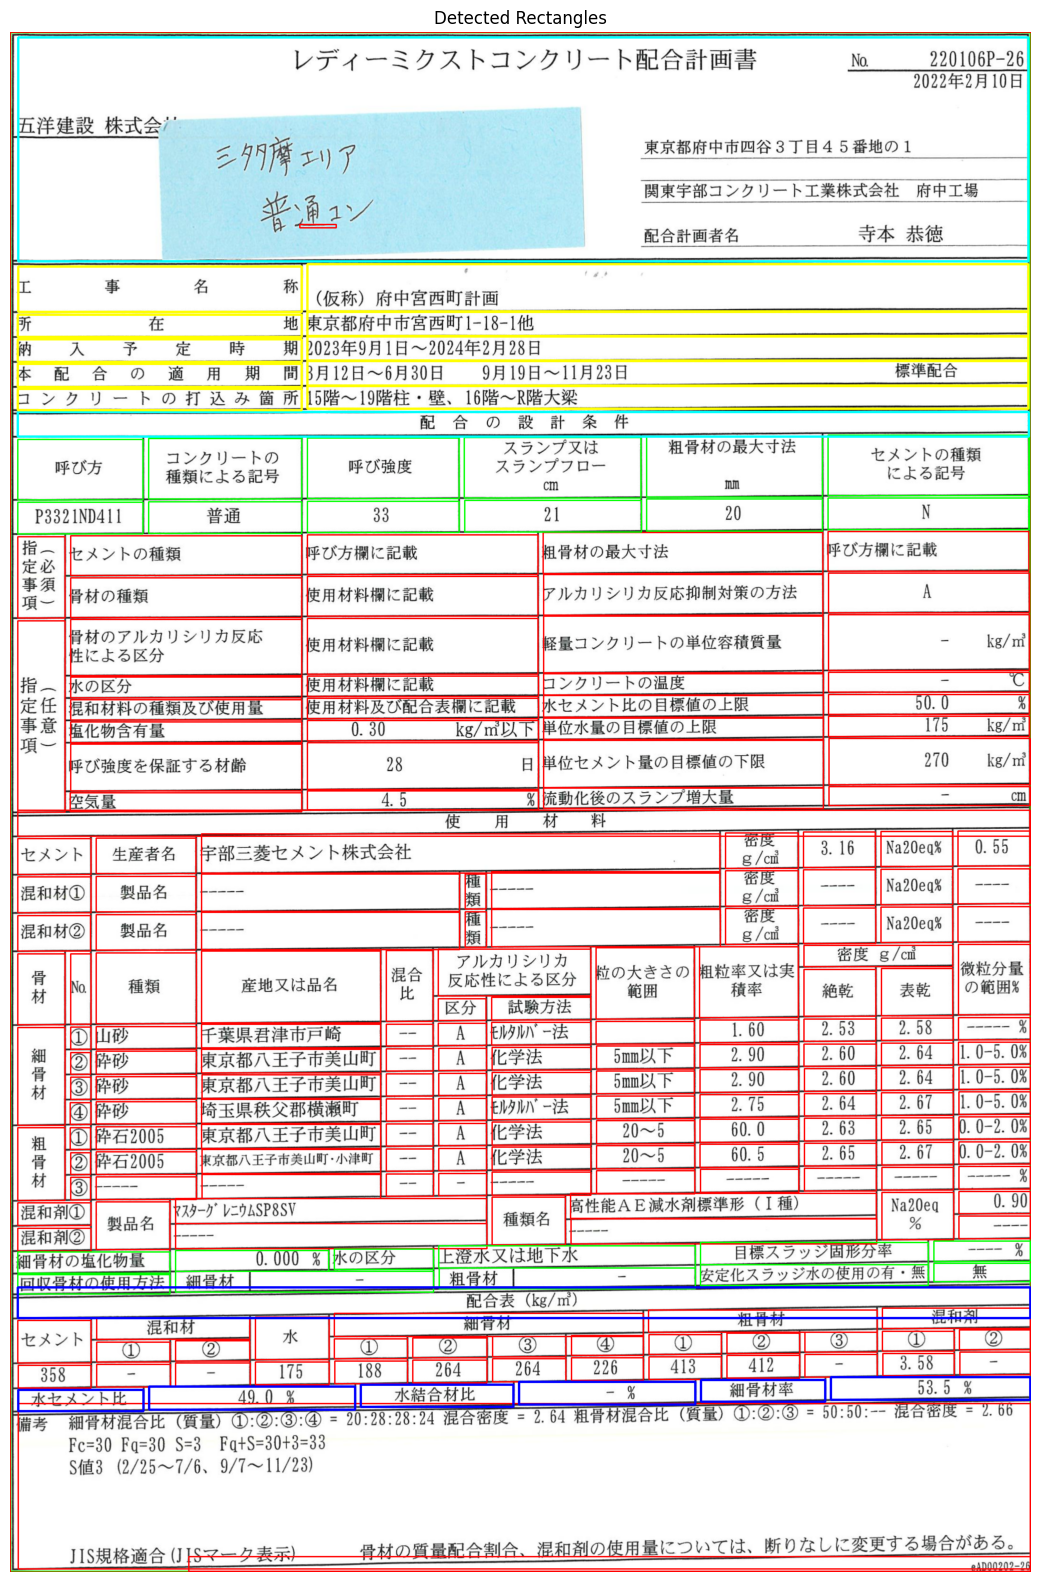

True

In [232]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Giả sử 'combined_image_dilated' là ảnh nhị phân chứa các đường ngang và dọc

# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(combined_image_dilated, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = warped.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    rectangles.append((x, y, w, h))
    cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ

# Sắp xếp các hình chữ nhật theo tọa độ y
rectangles_sorted = sorted(rectangles, key=lambda rect: rect[1])

# Tìm nhóm hình chữ nhật đứng cạnh nhau
def find_adjacent_rectangles(rectangles, max_y_diff=20, max_height_diff=15, min_width_ratio=0.7):
    groups = []
    groups_percent = []

    for i in range(len(rectangles)):
        group = [rectangles[i]]
        for j in range(len(rectangles)):
            if j != i:
                y_diff = abs(rectangles[j][1] - rectangles[i][1])
                height_diff = abs(rectangles[j][3] - rectangles[i][3])
                if y_diff < max_y_diff and height_diff < max_height_diff:
                    group.append(rectangles[j])
        if len(group) >= 5 and len(group) <= 6:
            groups.append(group)
        if len(group) == 6:
            groups_percent.append(group)
    return groups, groups_percent

adjacent_groups, groups_percent = find_adjacent_rectangles(rectangles_sorted)

# Tìm nhóm có tổng chiều dài chiếm phần lớn chiều dài hình ảnh
image_height, image_width = combined_image_dilated.shape
selected_groups = []
percent_group = []

for group in adjacent_groups:
    total_width = sum([w for (x, y, w, h) in group])
    if total_width > image_width * 0.8:
        selected_group = group
        selected_groups.append(selected_group)

for group in groups_percent:
    total_width = sum([w for (x, y, w, h) in group])
    if total_width > image_width * 0.9:
        percent_group = group

# Hiển thị ảnh với nhóm bounding box đã chọn
if selected_groups:
    for selected_group in selected_groups:
        for (x, y, w, h) in selected_group:
            cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Vẽ bounding box màu xanh lá

if percent_group:
    for (x, y, w, h) in percent_group:
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 0, 0), 4)  # Vẽ bounding box màu xanh duowng

# In ra các hình chữ nhật trích xuất được
print("Selected Rectangles:")
if selected_groups:
    for i, (x, y, w, h) in enumerate(selected_groups[0], 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
else:
    print("No group of rectangles found that meets the criteria.")

# In ra các nhóm 6 hình chữ nhật chứa dữ liệu phần trăm
print("Percent Rectangles:")
# In ra tọa độ x(max) và y(max) của percent_group
x_max_2 = 0
y_max_2 = 0
if percent_group:
    x_max_2 = max(rect[0] + rect[2] for rect in percent_group)
    y_max_2 = max(rect[1] + rect[3] for rect in percent_group)
    
    print("Percent Rectangles:")
    for i, (x, y, w, h) in enumerate(percent_group, 1):
        print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")
    
    print(f"x(max) = {x_max_2}, y(max) = {y_max_2}")
else:
    print("No group of rectangles found that meets the criteria.")

# Xác định rectangle chứa đầu mục yêu cầu thứ hai
threshold_width = 0.9 * image_width

# Duyệt ngược mảng rectangles_sorted để tìm hình chữ nhật thỏa mãn điều kiện
selected_rectangle = None
for rect in reversed(rectangles_sorted):
    x, y, w, h = rect
    if y < y_max_2 and w > threshold_width and h < image_width * 0.1:
        selected_rectangle = rect
        break
x_min_2 = 0
y_min_2 = 0
if selected_rectangle:
    x_min_2, y_min_2, w, h = selected_rectangle
    print(f"Selected Rectangle: x={x_min_2}, y={y_min_2}, width={w}, height={h}")
    cv2.rectangle(line_image, (x_min_2, y_min_2), (x_min_2 + w, y_min_2 + h), (255, 0, 0), 4) 

else:
    print("No rectangle found that meets the criteria.")

print(f"Second data area: x_min_2={x_min_2}, y_min_2={y_min_2}, x_max_2={x_max_2}, y_max_2={y_max_2}")


# Xây dựng việc tìm kiếm vùng nội dung thứ 3 (được kẹp giữa hai dùng chiếm gần hết chiều dài bức ảnh)
selected_rectangle_1 = None
selected_rectangle_2 = None
count = 1
for rect in rectangles_sorted:
    x, y, w, h = rect
    if w > threshold_width and h < image_height * 0.3 and h > image_width * 0.1 and count == 1:
        selected_rectangle_1 = rect
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 255, 0), 4) 
        print(selected_rectangle_1)
        count += 1
    else:
        if w > threshold_width and h < image_height * 0.3 and count == 2:
            selected_rectangle_2 = rect
            cv2.rectangle(line_image, (x, y), (x + w, y + h), (255, 255, 0), 4) 
            print(selected_rectangle_2)
            break

y_min_3 = None
y_max_3 = None
info_row_group = []

if selected_rectangle_1 and selected_rectangle_2:
    y_min_3 = selected_rectangle_1[1] + selected_rectangle_1[3] - 10
    y_max_3 = selected_rectangle_2[1] + 10

    for rect in rectangles_sorted:
        if rect[1] > y_min_3 and rect[1] < y_max_3 and rect[3] < image_height * 0.1 and rect[2] > image_width * 0.1:
            info_row_group.append(rect)
            cv2.rectangle(line_image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 255), 4)
        if len(info_row_group) >= 10:
            break

# # Xây dựng tìm kiếm vùng nội dung thứ 4 (vùng chứa trong thành phần nằm ở đầu của trang)
result_area_4 = None
if selected_rectangle_1:
    result_area_4 = selected_rectangle_1

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Rectangles')
plt.show()

image_output_path = 'image_output_layout/image_output_table_' + str(number_image) + '.jpg'
cv2.imwrite(image_output_path, line_image)